# Cole-Cole

There are various different definitions of a cole-cole model. The one we use here is given by

$$
\sigma^* = \sigma_\infty + \frac{\sigma_0 - \sigma_\infty}{1 + (i\omega\tau)^c}\ ,
$$

but you can adjust the function `get_cole_cole` below to fit another model.

## WARNING

This is work in progress and might change anytime. **It is not working with the stable release of empymod**. You have to use the branch [cole-cole](https://github.com/empymod/empymod/tree/cole-cole).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from empymod import bipole, versions
from empymod.utils import _check_var

## Define the Cole-Cole model

In [2]:
def get_cole_cole(cond, freq, aniso, etaH, etaV):
    """Calculate Cole-Cole.
    
    We will feed this to empymod.dipole or empymod.bipole. You have to leave
    the input signature [(cond, freq, aniso, etaH, etaV)] and the output
    signature [etaH, etaV] unchanged, but everything else you can adjust
    to your needs.

    By default, etaH/etaV are calculated like this:
    
      etaH = 1/res + 2j*np.pi*freq*epermH*epsilon_0
      etaV = 1/(res*aniso**2) + 2j*np.pi*freq*epermV*epsilon_0

    With this function we recalculate it. We replace the real part, the
    conductivity, by a complex, frequency-dependent conductivity. Then we
    add back the imaginary part coming from eperm (basically zero for low
    frequencies).

    """   
    # Get required variables from cond, check them.
    cond_0 = _check_var(cond['cond_0'], float, 1, 'cond_0', etaH[0, :].shape)
    cond_8 = _check_var(cond['cond_8'], float, 1, 'cond_8', cond_0.shape)
    tau = _check_var(cond['tau'], float, 1, 'cond_tau', cond_0.shape)
    c = _check_var(cond['c'], float, 1, 'cond_c', cond_0.shape)

    # Calculate complex conductivity from cole-cole
    iomega = 2j*np.pi*freq
    condH = cond_8 + (cond_0-cond_8)/(1 + np.outer(iomega, tau)**c)
    condV = condH/aniso**2

    # Add electric permittivity
    etaH = condH + 1j*etaH.imag
    etaV = condV + 1j*etaV.imag

    return etaH, etaV

## Example


:: empymod END; runtime = 0:00:00.043116 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.058030 :: 1 kernel call(s)



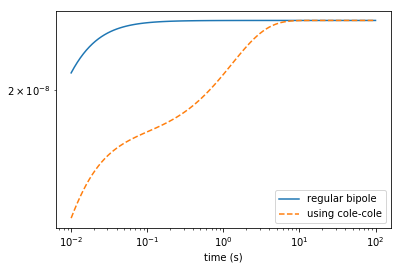

In [3]:
# Times
times = np.logspace(-2, 2, 101)

# Model parameter
model = {
    'src': [0, 0, 1e-5, 0, 0],
    'rec': [500, 0, 1e-5, 0, 0],
    'depth': 0,
    'epermH': [0, 1],  # To improve early times in land CSEM
    'epermV': [0, 1],  # (diffusive approximation for airwave)
    'freqtime': times,
    'signal': 1,
}

# Resistivity (for regular bipole-result)
res = np.array([2e14, 10])

# Define `cond`, it MUST contain two entries:
# - 'res': Used to calculate regular etaH, etaV
# - 'func': The Cole-Cole function
# Aditionally all parameters you use in `func`.
cond = {
    'res': res,
    'cond_0': 1/res, # cond_0  (we take the inverse of res here)
    'cond_8': [2e-14, 0.15],
    'tau': [1, 1],
    'c': [1, 1],
    'func': get_cole_cole
}

out_cole = bipole(res=cond, **model)
out_dip = bipole(res=[2e14, 10], **model)

plt.figure()
plt.plot(times, out_dip, '-', label='regular bipole')
plt.plot(times, out_cole, '--', label='using cole-cole')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('time (s)')
plt.show()

In [4]:
versions('HTML')